In [1]:
from logparser import get_events_from
import matplotlib.pyplot as plt
import numpy as np

In [2]:
events = get_events_from("logs/gcbench")
minor = [event for event in events if event["task"] == "gc-minor"]
major = [event for event in events if event["task"] == "gc-collect-step"]
both = [event for event in events if event["task"] == "gc-minor" or event["task"] == "gc-collect-step"]

In [3]:
time_minor_distance = [event["time-last-minor-gc"] for event in minor]
memory_used = [event["total-memory-used"] for event in minor]
acc = 0
time_minor = [0]
for time_dist in time_minor_distance[1:]:
    acc += time_dist
    time_minor.append(acc)

Text(0.5, 1.0, 'y: heap usage (only minor gc), x: time')

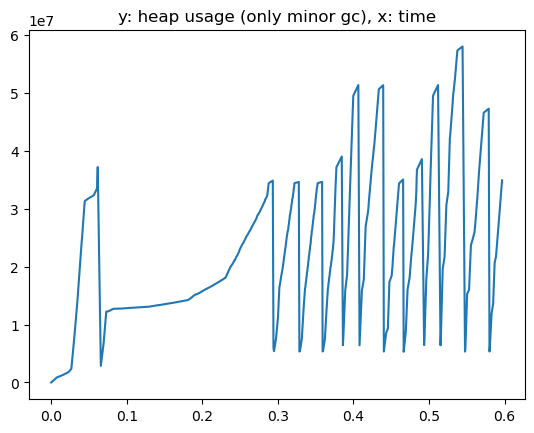

In [4]:
plt.plot(time_minor,memory_used)
plt.title("y: heap usage (only minor gc), x: time")

In [31]:
time_minor_start = np.array([int(event["start"], 16)  for event in minor], dtype=float)
start_instruction = time_minor_start[0]
time_minor_start -= start_instruction

time_threshold , threshold, begin_major_gc, end_major_gc = [], [], [],[]
for event in events:
    if event["task"] == "gc-collect-done":
        time_threshold.append(int(event["start"], 16) - start_instruction)
        threshold.append(event["new-threshold"])
    
    elif "FINALIZING" in event["text"]:
        end_major_gc.append(int(event["end"], 16) - start_instruction)
    # assumption: SCANNING only in start and final event
    elif event["task"] == "gc-collect-step" and "SCANNING" in event["text"]:
        begin_major_gc.append(int(event["start"], 16) - start_instruction)
    

def heap_limit(instruction_number):
    index = np.searchsorted(time_threshold, instruction_number, 'right')
    return np.array(threshold)[index-1]

tn = np.linspace(time_threshold[0], time_minor_start[-1], 300)
yn = heap_limit(tn)

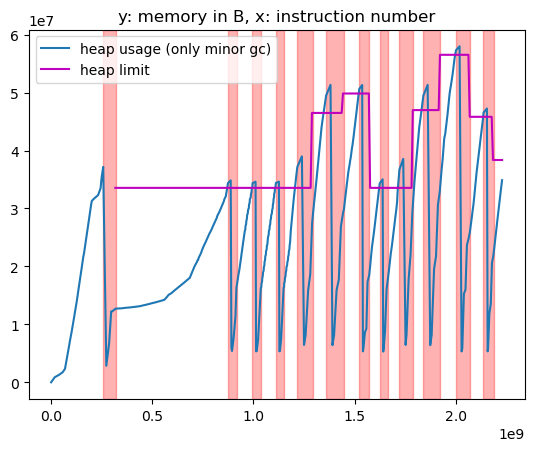

In [32]:
plt.plot(time_minor_start,memory_used, label="heap usage (only minor gc)")
plt.plot(tn, yn, 'm', label="heap limit")
for i in range(len(begin_major_gc)):
    plt.axvspan(begin_major_gc[i], end_major_gc[i], alpha=0.3, color='red')
plt.title("y: memory in B, x: instruction number")
plt.legend()